## Consumption of Pornographic Content by Age and Education

In [1]:
# import the necessary libraries 
%matplotlib inline 
import seaborn as sns 
import matplotlib.pyplot as plt
import matplotlib.ticker as tkr

import pandas as pd
import gc

# set aesthetics
sns.set_style("whitegrid")

### Load Data

The 2016 comScore data are already grouped by machine_id and domain_name. The data has four columns: 
a. machine_id, 
b. domain_name, 
c. total duration of visits to the site, 
d. number of visits

Each row gives the total visits to and total duration spent on a domain.

We merge this with data from pydomains and the Trusted Source API. We then calculate the time spent on and total visits to pornographic domains based on a variety of measures. We also create two other columns that track proportion of visits, and proportion of time.

In [2]:
YEAR = 2016

In [3]:
# Read in data
idf = pd.read_csv('/opt/data/comscore/pydomains/app2/cs%04d_grp_machine_domain.csv.bz2' % YEAR)

In [4]:
# Load the pydomains data
pydom_df = pd.read_csv('/opt/data/comscore/pydomains/cs%04d_unique_domains_pydomains.csv.bz2' % YEAR, usecols=['domain_names', 'shalla_2017_cat', 'pred_shalla_2017_lab', 'pred_shalla_2017_prob_porn', 'pred_toulouse_2017_prob_adult'], encoding='latin1')
# rename column
pydom_df.rename(columns={'domain_names': 'domain_name'}, inplace=True)

In [5]:
# Load trusted data
tdf = pd.read_csv('/opt/data/comscore/pydomains/comScore_unique_2004.csv')
# rename column
tdf.rename(columns={'unique_url': 'domain_name', 'url_class': 'trusted_cat'}, inplace=True)

### Left join Trusted Source and PyDomains

In [6]:
# Left join with pydomain
pdf = idf.merge(pydom_df, how='left', on='domain_name')

# Left join with Trusted
pdf = pdf.merge(tdf, how='left', on='domain_name')

For domains that are already in the labeled datasets, we use the labels from there.

In [7]:
# -1 for Unknown, 0 - No, 1 - Yes
pdf['shalla_trusted_porn'] = 0
pdf.loc[pdf.shalla_2017_cat.isnull() & (pdf.trusted_cat.isnull() | (pdf.trusted_cat == 'UNKNOWN')), 'shalla_trusted_porn'] = -1
pdf.loc[pdf.shalla_2017_cat.notnull() & pdf.shalla_2017_cat.str.contains('porn', case=False), 'shalla_trusted_porn'] = 1
pdf.loc[pdf.trusted_cat.notnull() & pdf.trusted_cat.str.contains('porn', case=False), 'shalla_trusted_porn'] = 1

pdf[['shalla_2017_cat', 'trusted_cat', 'shalla_trusted_porn']].head()

,shalla_2017_cat,trusted_cat,shalla_trusted_porn
0,NaN,NaN,-1
1,NaN,Finance/Banking,0
2,NaN,NaN,-1
3,NaN,NaN,-1
4,NaN,NaN,-1


### Unique domain names

In [8]:
udf = pdf.drop_duplicates(subset='domain_name').copy()
# Total unique domains
len(udf)

550745

### Total number of domains for which the label must be imputed

Curated lists generally only information about the kind of content hosted by a small fraction of domains. Commercial APIs generally are a lot better but still miss a sizable chunk. In Shallist, for instance, only about 22% of the domains in the data have category assigned to them (see below). For Trusted Source, the commensurate number is nearly 86%. In all, we know the category of about 86% of the domains.

In [9]:
# -1 for Unknown, 0 - No, 1 - Yes
udf['shalla_cat_porn'] = -1
udf.loc[udf.shalla_2017_cat.notnull() & (udf.shalla_2017_cat.str.contains('unknown', case=False) == False), 'shalla_cat_porn'] = 0
udf.loc[udf.shalla_2017_cat.notnull() & udf.shalla_2017_cat.str.contains('porn', case=False), 'shalla_cat_porn'] = 1
udf.groupby('shalla_cat_porn').agg({'domain_name': 'count'})/udf.shape[0]

,domain_name
shalla_cat_porn,
-1,0.923564
0,0.048634
1,0.027802


In [10]:
# -1 for Unknown, 0 - No, 1 - Yes
udf['trusted_cat_porn'] = -1
udf.loc[udf.trusted_cat.notnull() & (udf.trusted_cat.str.contains('unknown', case=False) == False), 'trusted_cat_porn'] = 0
udf.loc[udf.trusted_cat.notnull() & udf.trusted_cat.str.contains('porn', case=False), 'trusted_cat_porn'] = 1
udf.groupby('trusted_cat_porn').agg({'domain_name': 'count'})/udf.shape[0]

,domain_name
trusted_cat_porn,
-1,0.868994
0,0.124824
1,0.006183


In [11]:
udf.groupby('shalla_trusted_porn').agg({'domain_name': 'count'})/udf.shape[0]

,domain_name
shalla_trusted_porn,
-1,0.831356
0,0.140297
1,0.028347


In [12]:
pdf['prob_shalla'] = pdf['pred_shalla_2017_prob_porn']
pdf.loc[pdf.shalla_trusted_porn == 1, 'prob_shalla'] = 1
pdf.loc[pdf.shalla_trusted_porn == 0, 'prob_shalla'] = 0

pdf['prob_toulouse'] = pdf['pred_toulouse_2017_prob_adult']
pdf.loc[pdf.shalla_trusted_porn == 1, 'prob_toulouse'] = 1
pdf.loc[pdf.shalla_trusted_porn == 0, 'prob_toulouse'] = 0

In [13]:
pdf['total_time_porn_shalla'] = pdf['prob_shalla'] * pdf['total_time']
pdf['total_time_porn_toulouse'] = pdf['prob_toulouse'] * pdf['total_time']

pdf['total_visits_porn_shalla'] = pdf['prob_shalla'] * pdf['total_visits']
pdf['total_visits_porn_toulouse'] = pdf['prob_toulouse'] * pdf['total_visits']

pdf.head()

,machine_id,domain_name,total_time,total_visits,pred_shalla_2017_lab,pred_shalla_2017_prob_porn,shalla_2017_cat,pred_toulouse_2017_prob_adult,trusted_cat,shalla_trusted_porn,prob_shalla,prob_toulouse,total_time_porn_shalla,total_time_porn_toulouse,total_visits_porn_shalla,total_visits_porn_toulouse
0,17549714,100dayloans.com,0,1,porn,0.570555,NaN,0.462511,NaN,-1,0.570555,0.462511,0.000000,0.000000,0.570555,0.462511
1,17549714,1fbusa.com,43,18,porn,0.385279,NaN,0.399219,Finance/Banking,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,17549714,2020panel.com,91,22,porn,0.639233,NaN,0.601877,NaN,-1,0.639233,0.601877,58.170167,54.770780,14.063117,13.241287
3,17549714,247-inc.net,46,32,porn,0.290664,NaN,0.327552,NaN,-1,0.290664,0.327552,13.370560,15.067390,9.301259,10.481663
4,17549714,4salelocal.net,1,1,recreation/travel,0.242972,NaN,0.399942,NaN,-1,0.242972,0.399942,0.242972,0.399942,0.242972,0.399942


In [14]:
agg_sum = {'total_time': sum, 'total_visits': sum}

agg_sum['total_time_porn_shalla'] = sum
agg_sum['total_time_porn_toulouse'] = sum

agg_sum['total_visits_porn_shalla'] = sum
agg_sum['total_visits_porn_toulouse'] = sum

In [15]:
# agg. total_time and total_visits by machine_id
gdf = pdf.groupby(['machine_id']).agg(agg_sum)

### We join the data with demographic data at the household level, recoding demographic codes to semantic labels.

In [16]:
# Load household level demographics data
dem_df = pd.read_csv('/opt/data/comscore/demographics_by_machine_id/demographics%d.csv' % YEAR, usecols = ['machine_id', 'hoh_oldest_age', 'hoh_most_education'])

age = {1: '18-20', 
       2: '21-24',
       3: '25-29', 
       4: '30-34',
       5: '35-39',
       6: '40-44',
       7: '45-49',
       8: '50-54',
       9: '55-59',
       10: '60-64',
       11: '65 and over',
       99: 'Missing'}

dem_df['hoh_oldest_age'] = dem_df['hoh_oldest_age'].replace(age)

# FIXME: replace '**' to 99
dem_df['hoh_most_education'] = dem_df['hoh_most_education'].astype(str).replace({
                                                                 '**': 99})

edu = {0: 'Less than a high school diploma',
           1: 'High school diploma or equivalent', 
           2: 'Some college but no degree', 
           3: 'Associate degree', 
           4: 'Bachelor’s degree',
           5: 'Graduate degree',
           99: 'Missing'}

dem_df['hoh_most_education'] = dem_df['hoh_most_education'].astype(int).replace(edu)

# Merge browsing data with demographics data
df = gdf.merge(dem_df, how = 'left', on = 'machine_id')

### Total time spent (total number of visits) on pornographic domains

Given the potential skew in these numbers, we also show quartiles.

In [17]:
df.head()

,machine_id,total_time,total_visits,total_time_porn_shalla,total_time_porn_toulouse,total_visits_porn_shalla,total_visits_porn_toulouse,hoh_most_education,hoh_oldest_age
0,17549714,36193,4147,2206.267300,3483.467975,465.155438,623.829723,Missing,40-44
1,66614909,8240,1540,296.184566,453.098685,96.570919,151.125553,Some college but no degree,60-64
2,66859433,138,9,4.466144,5.896013,2.085508,2.629506,Missing,25-29
3,69370447,1810,105,54.854156,125.238533,10.224826,17.834540,Missing,55-59
4,70605319,3099,288,549.326082,623.127739,53.427575,70.873977,Missing,21-24


We select the columns that we intend to show.

In [18]:
sel_cols = pd.IndexSlice[:, ['mean', '25%', '50%', '75%']]
grp_visits = ['total_visits_porn_shalla', 'total_visits_porn_toulouse']
grp_time = ['total_time_porn_shalla', 'total_time_porn_toulouse']

### Average Number of Visits to Pornographic Sites by Age

Given the skew, we focus our discussion on the medians. A consistent pattern emerges across all four versions of our measure: 18--20 visit the pornographic domains the most often but after that, there is a sharp decline and then a modest upward trend peaking at 40--44 after which the average number of visits roughly monotonically decline. You see the same rough pattern in the average time spent.

Perhaps yet more importantly, it seems the average number of visits are pretty low. We concur. And that means that the absolute size of the differences is pretty small too even though the relative size may look big. The more serious concern is about the data. We don't have a lot to say about it.

In [19]:
df.groupby(['hoh_oldest_age'])[grp_visits].describe().round(1).loc[:, sel_cols].astype('int')

total_visits_porn_shalla               \
                                   mean 25% 50%  75%   
hoh_oldest_age                                         
18-20                                75   8  27   79   
21-24                               106   8  30   90   
25-29                               118  10  34  109   
30-34                               123  11  40  119   
35-39                               127  12  42  120   
40-44                               133  12  42  126   
45-49                               138  11  41  126   
50-54                               139   7  33  121   
55-59                               172  13  49  156   
60-64                               227  17  64  197   
65 and over                         217  17  61  188   
Missing                              18   9  17   26   

               total_visits_porn_toulouse               
                                     mean 25% 50%  75%  
hoh_oldest_age                                          
18-20                                 103  12  41  112  
21-24                                 138  13  44  130  
25-29                                 156  15  51  158  
30-34                                 165  17  59  170  
35-39                                 168  19  63  175  
40-44                                 177  18  63  183  
45-49                                 180  16  61  183  
50-54                                 179  11  49  177  
55-59                                 220  19  73  224  
60-64                                 284  27  94  277  
65 and over                           270  26  88  261  
Missing                                28  13  23   38

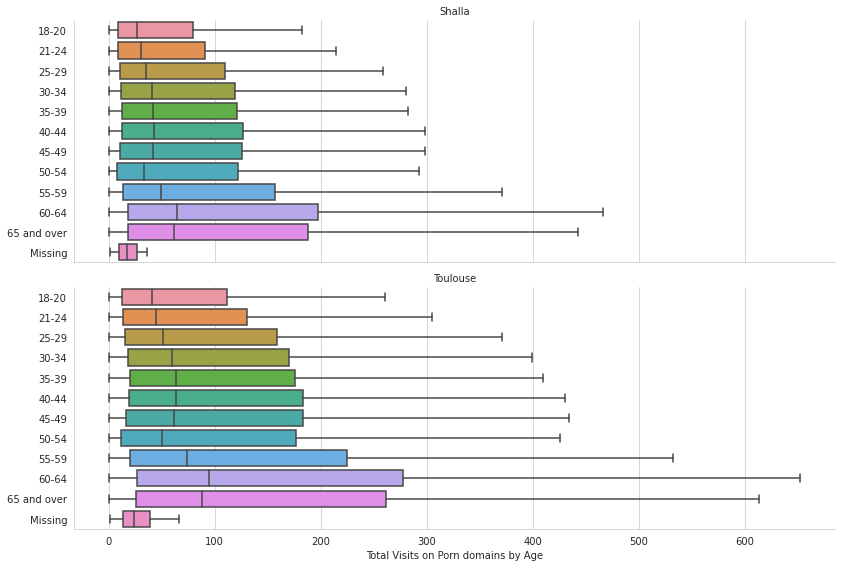

In [20]:
adf = pd.melt(df, id_vars=['hoh_oldest_age'], value_vars=grp_visits, var_name='model', value_name='total_visit')
adf['model'] = adf['model'].replace({'total_visits_porn_shalla': 'Shalla', 'total_visits_porn_toulouse': 'Toulouse'})

g = sns.catplot(x="total_visit", y="hoh_oldest_age",
                col='model', col_wrap=1, height=4, aspect=3,
                kind="box", data=adf, showfliers=False, order=age.values());
g.set_titles(row_template = '{row_name}', col_template = '{col_name}')
g.set_ylabels('');
g.set_xlabels('Total Visits on Porn domains by Age')

for ax in g.axes.flatten():
    ax.xaxis.set_major_locator(tkr.MultipleLocator(100))
    ax.xaxis.set_minor_locator(tkr.MultipleLocator(10))

g.savefig('./total_visits_porn_age_2016.eps', format='eps', dpi=300)

### Average Time Spent on Pornographic Sites by Age

In [21]:
df.groupby(['hoh_oldest_age'])[grp_time].describe().round(1).loc[:, sel_cols].astype('int')

total_time_porn_shalla                total_time_porn_toulouse  \
                                 mean 25%  50%   75%                     mean   
hoh_oldest_age                                                                  
18-20                             888  41  188   671                     1205   
21-24                            1356  44  208   786                     1781   
25-29                            1583  58  243   964                     2106   
30-34                            1541  69  289  1032                     2121   
35-39                            1669  75  311  1057                     2243   
40-44                            1759  73  305  1088                     2345   
45-49                            1812  58  285  1044                     2400   
50-54                            1657  39  228   980                     2141   
55-59                            2008  73  342  1274                     2595   
60-64                            2530  97  415  1618                     3178   
65 and over                      2385  96  379  1432                     2975   
Missing                           142  94  134   183                      199   

                                
                25%  50%   75%  
hoh_oldest_age                  
18-20            61  275   982  
21-24            65  315  1164  
25-29            90  369  1355  
30-34           108  434  1526  
35-39           117  462  1538  
40-44           111  469  1598  
45-49            91  425  1545  
50-54            58  341  1387  
55-59           113  502  1837  
60-64           151  606  2176  
65 and over     142  550  1981  
Missing         102  144   240

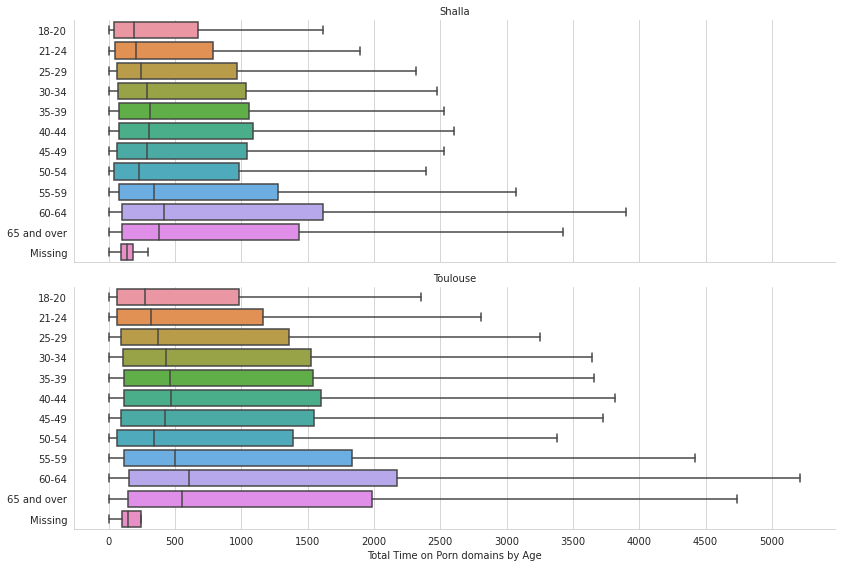

In [22]:
adf = pd.melt(df, id_vars=['hoh_oldest_age'], value_vars=grp_time, var_name='model', value_name='total_time')
adf['model'] = adf['model'].replace({'total_time_porn_shalla': 'Shalla', 'total_time_porn_toulouse': 'Toulouse'})

g = sns.catplot(x="total_time", y="hoh_oldest_age",
                col='model', col_wrap=1, height=4, aspect=3,
                kind="box", data=adf, showfliers=False, order=age.values());
g.set_titles(row_template = '{row_name}', col_template = '{col_name}')
g.set_ylabels('');
g.set_xlabels('Total Time on Porn domains by Age')

for ax in g.axes.flatten():
    ax.xaxis.set_major_locator(tkr.MultipleLocator(500))
    ax.xaxis.set_minor_locator(tkr.MultipleLocator(100))

g.savefig('./total_time_porn_age_2016.eps', format='eps', dpi=300)

### Average Number of Visits to Pornographic Sites by Education

As education levels increase, the average number of visits go down. Households where the most educated person in the household has a graduate degree visit pornographic sites less often and spent less time on them than households where the most educated person has less than a HS diploma.

In [23]:
df.groupby(['hoh_most_education'])[grp_visits].describe().round(1).loc[:, sel_cols].astype('int').reindex(edu.values())

total_visits_porn_shalla                     \
                                                      mean   25%   50%    75%   
hoh_most_education                                                              
Less than a high school diploma                        NaN   NaN   NaN    NaN   
High school diploma or equivalent                    147.0  16.0  49.0  136.0   
Some college but no degree                           179.0  18.0  56.0  159.0   
Associate degree                                     181.0  21.0  64.0  170.0   
Bachelor’s degree                                    195.0  24.0  75.0  199.0   
Graduate degree                                      216.0  26.0  90.0  259.0   
Missing                                              108.0   4.0  19.0   76.0   

                                  total_visits_porn_toulouse               \
                                                        mean   25%    50%   
hoh_most_education                                                          
Less than a high school diploma                          NaN   NaN    NaN   
High school diploma or equivalent                      193.0  25.0   73.0   
Some college but no degree                             231.0  28.0   83.0   
Associate degree                                       234.0  31.0   95.0   
Bachelor’s degree                                      254.0  37.0  112.0   
Graduate degree                                        283.0  40.0  135.0   
Missing                                                137.0   7.0   29.0   

                                          
                                     75%  
hoh_most_education                        
Less than a high school diploma      NaN  
High school diploma or equivalent  195.0  
Some college but no degree         228.0  
Associate degree                   243.0  
Bachelor’s degree                  282.0  
Graduate degree                    361.0  
Missing                            109.0

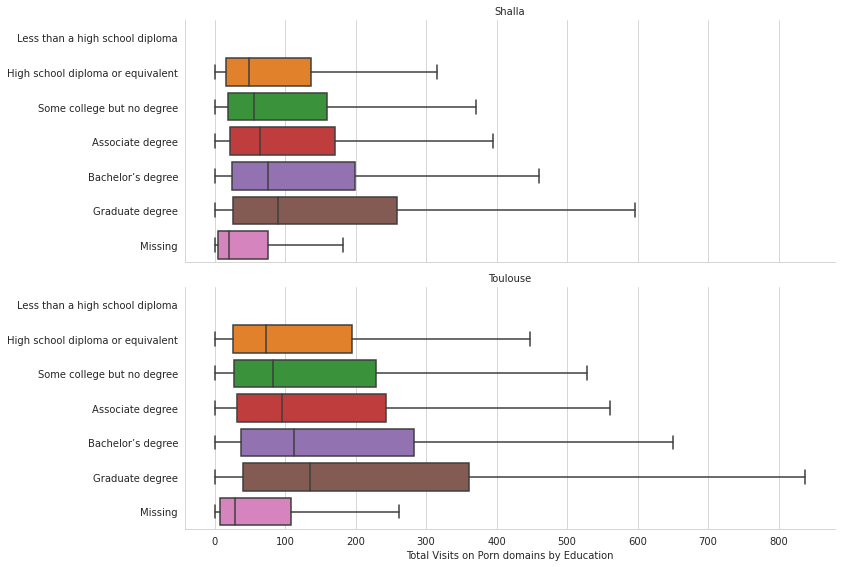

In [24]:
adf = pd.melt(df, id_vars=['hoh_most_education'], value_vars=grp_visits, var_name='model', value_name='total_visit')
adf['model'] = adf['model'].replace({'total_visits_porn_shalla': 'Shalla', 'total_visits_porn_toulouse': 'Toulouse'})

g = sns.catplot(x="total_visit", y="hoh_most_education",
                col='model', col_wrap=1, height=4, aspect=3,
                kind="box", data=adf, showfliers=False, order=edu.values());
g.set_titles(row_template = '{row_name}', col_template = '{col_name}')
g.set_ylabels('');
g.set_xlabels('Total Visits on Porn domains by Education')

for ax in g.axes.flatten():
    ax.xaxis.set_major_locator(tkr.MultipleLocator(100))
    ax.xaxis.set_minor_locator(tkr.MultipleLocator(10))

g.savefig('./total_visits_porn_educ_2016.eps', format='eps', dpi=300)

### Average Time Spent on Pornographic Sites by Education

In [25]:
df.groupby(['hoh_most_education'])[grp_time].describe().round(1).loc[:, sel_cols].astype('int').reindex(edu.values())

total_time_porn_shalla                \
                                                    mean    25%    50%   
hoh_most_education                                                       
Less than a high school diploma                      NaN    NaN    NaN   
High school diploma or equivalent                 1686.0   96.0  347.0   
Some college but no degree                        2141.0  109.0  385.0   
Associate degree                                  2175.0  126.0  433.0   
Bachelor’s degree                                 2267.0  142.0  507.0   
Graduate degree                                   2307.0  152.0  665.0   
Missing                                           1363.0   21.0  128.0   

                                          total_time_porn_toulouse         \
                                      75%                     mean    25%   
hoh_most_education                                                          
Less than a high school diploma       NaN                      NaN    NaN   
High school diploma or equivalent  1114.0                   2213.0  149.0   
Some college but no degree         1313.0                   2763.0  166.0   
Associate degree                   1428.0                   2825.0  192.0   
Bachelor’s degree                  1655.0                   2975.0  218.0   
Graduate degree                    2405.0                   3200.0  236.0   
Missing                             643.0                   1767.0   33.0   

                                                  
                                     50%     75%  
hoh_most_education                                
Less than a high school diploma      NaN     NaN  
High school diploma or equivalent  529.0  1658.0  
Some college but no degree         573.0  1880.0  
Associate degree                   649.0  2031.0  
Bachelor’s degree                  754.0  2318.0  
Graduate degree                    980.0  3291.0  
Missing                            189.0   924.0

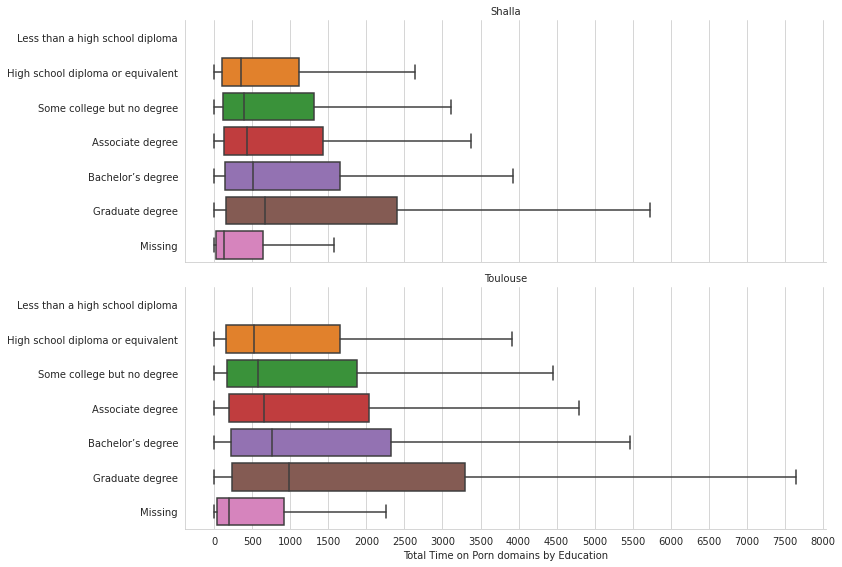

In [26]:
adf = pd.melt(df, id_vars=['hoh_most_education'], value_vars=grp_time, var_name='model', value_name='total_time')
adf['model'] = adf['model'].replace({'total_time_porn_shalla': 'Shalla', 'total_time_porn_toulouse': 'Toulouse'})

g = sns.catplot(x="total_time", y="hoh_most_education",
                col='model', col_wrap=1, height=4, aspect=3,
                kind="box", data=adf, showfliers=False, order=edu.values());
g.set_titles(row_template = '{row_name}', col_template = '{col_name}')
g.set_ylabels('');
g.set_xlabels('Total Time on Porn domains by Education')

for ax in g.axes.flatten():
    ax.xaxis.set_major_locator(tkr.MultipleLocator(500))
    ax.xaxis.set_minor_locator(tkr.MultipleLocator(100))

g.savefig('./total_time_porn_educ_2016.eps', format='eps', dpi=300)

### Proportion of Time Spent on (Proportion of Visits to) Pornographic Domains

Do we see the patterns because it just captures that certain people spend more time online? To check that we look at proportions.

The data are clear---as people get older, they generally spend a smaller proportion of time on pornographic websites with perceptible drop-offs after 50--54. Splitting by education also shows that the declining trend is a result of people in households where education level is higher spending less time on pornographic domains.

In [27]:
grp_prop_visits = []
for g in grp_visits:
    df['prop_' + g] = df[g]/df['total_visits'] 
    grp_prop_visits.append('prop_'  + g)

grp_prop_time = []
for g in grp_time:
    df['prop_' + g] = df[g]/df['total_time'] 
    grp_prop_time.append('prop_'  + g)    

#### By Age

In [28]:
df.groupby(['hoh_oldest_age'])[grp_prop_visits].mean().round(3)

,prop_total_visits_porn_shalla,prop_total_visits_porn_toulouse
hoh_oldest_age,,
18-20,0.122,0.169
21-24,0.128,0.175
25-29,0.129,0.176
30-34,0.123,0.169
35-39,0.122,0.167
40-44,0.121,0.165
45-49,0.126,0.171
50-54,0.127,0.172
55-59,0.129,0.172


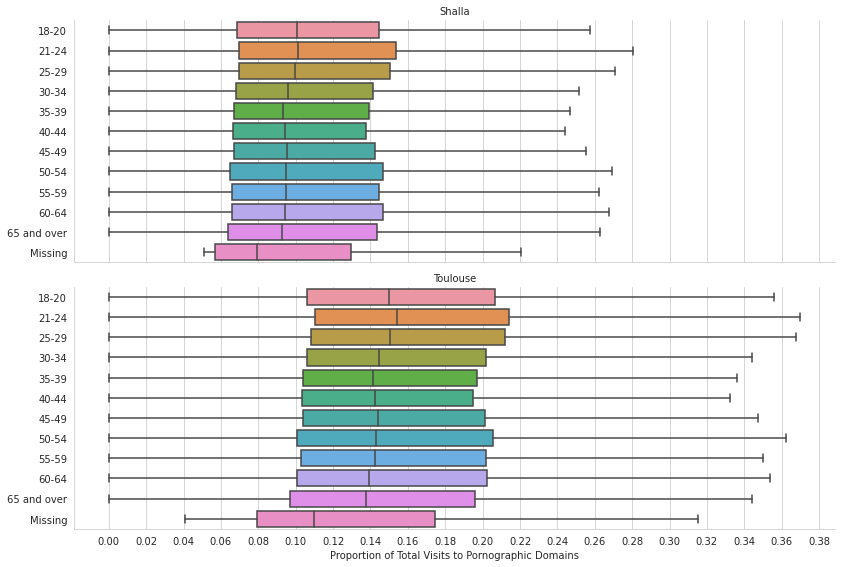

In [29]:
adf = pd.melt(df, id_vars=['hoh_oldest_age'], value_vars=grp_prop_visits, var_name='model', value_name='prop_total_visits_porn_prob')
adf['model'] = adf['model'].replace({'prop_total_visits_porn_shalla': 'Shalla', 'prop_total_visits_porn_toulouse': 'Toulouse'})

g = sns.catplot(x="prop_total_visits_porn_prob", y="hoh_oldest_age",
                col='model', col_wrap=1, height=4, aspect=3,
                kind="box", data=adf, showfliers=False, order=age.values());
g.set_titles(row_template = '{row_name}', col_template = '{col_name}')
g.set_ylabels('');
g.set_xlabels('Proportion of Total Visits to Pornographic Domains')

for ax in g.axes.flatten():
    ax.xaxis.set_major_locator(tkr.MultipleLocator(0.02))
    ax.xaxis.set_minor_locator(tkr.MultipleLocator(0.005))

g.savefig('./prop_total_visits_porn_age_2016.eps', format='eps', dpi=300)

In [30]:
df.groupby(['hoh_oldest_age'])[grp_prop_time].mean().round(3)

,prop_total_time_porn_shalla,prop_total_time_porn_toulouse
hoh_oldest_age,,
18-20,0.102,0.140
21-24,0.109,0.148
25-29,0.111,0.150
30-34,0.105,0.143
35-39,0.106,0.143
40-44,0.104,0.141
45-49,0.109,0.147
50-54,0.112,0.148
55-59,0.112,0.147


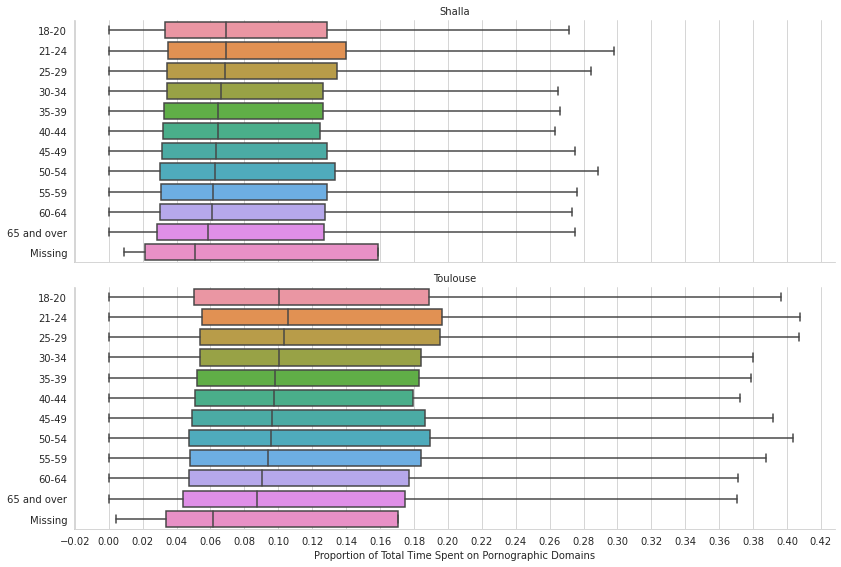

In [31]:
adf = pd.melt(df, id_vars=['hoh_oldest_age'], value_vars=grp_prop_time, var_name='model', value_name='prop_total_time_porn_prob')
adf['model'] = adf['model'].replace({'prop_total_time_porn_shalla': 'Shalla', 'prop_total_time_porn_toulouse': 'Toulouse'})

g = sns.catplot(x="prop_total_time_porn_prob", y="hoh_oldest_age",
                col='model', col_wrap=1, height=4, aspect=3,
                kind="box", data=adf, showfliers=False, order=age.values());
g.set_ylabels('');
g.set_titles(row_template = '{row_name}', col_template = '{col_name}')
g.set_xlabels('Proportion of Total Time Spent on Pornographic Domains')

for ax in g.axes.flatten():
    ax.xaxis.set_major_locator(tkr.MultipleLocator(0.02))
    ax.xaxis.set_minor_locator(tkr.MultipleLocator(0.005))

g.savefig('./prop_total_time_porn_age_2016.eps', format='eps', dpi=300)

#### By Education

In [32]:
df.groupby(['hoh_most_education'])[grp_prop_visits].mean().round(3).reindex(edu.values())

,prop_total_visits_porn_shalla,prop_total_visits_porn_toulouse
hoh_most_education,,
Less than a high school diploma,NaN,NaN
High school diploma or equivalent,0.120,0.166
Some college but no degree,0.123,0.167
Associate degree,0.122,0.165
Bachelor’s degree,0.122,0.164
Graduate degree,0.121,0.162
Missing,0.133,0.179


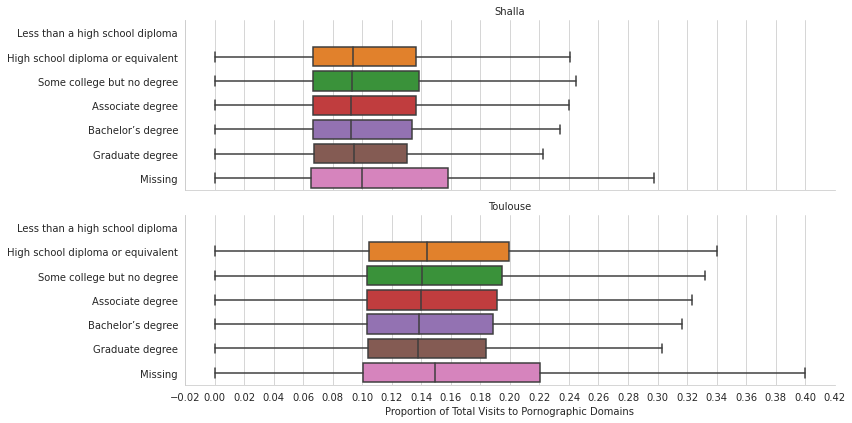

In [33]:
adf = pd.melt(df, id_vars=['hoh_most_education'], value_vars=grp_prop_visits, var_name='model', value_name='prop_total_visits_porn_prob')
adf['model'] = adf['model'].replace({'prop_total_visits_porn_shalla': 'Shalla', 'prop_total_visits_porn_toulouse': 'Toulouse'})

g = sns.catplot(x="prop_total_visits_porn_prob", y="hoh_most_education",
                col='model', col_wrap=1, height=3, aspect=4,
                kind="box", data=adf, showfliers=False, order=edu.values());
g.set_ylabels('');
g.set_titles(row_template = '{row_name}', col_template = '{col_name}')
g.set_xlabels('Proportion of Total Visits to Pornographic Domains')

for ax in g.axes.flatten():
    ax.xaxis.set_major_locator(tkr.MultipleLocator(0.02))
    ax.xaxis.set_minor_locator(tkr.MultipleLocator(0.005))

g.savefig('./prop_total_visits_porn_edu_2016.eps', format='eps', dpi=300)

In [34]:
df.groupby(['hoh_most_education'])[grp_prop_time].mean().round(3).reindex(edu.values())

,prop_total_time_porn_shalla,prop_total_time_porn_toulouse
hoh_most_education,,
Less than a high school diploma,NaN,NaN
High school diploma or equivalent,0.101,0.138
Some college but no degree,0.103,0.137
Associate degree,0.104,0.137
Bachelor’s degree,0.103,0.136
Graduate degree,0.101,0.133
Missing,0.120,0.158


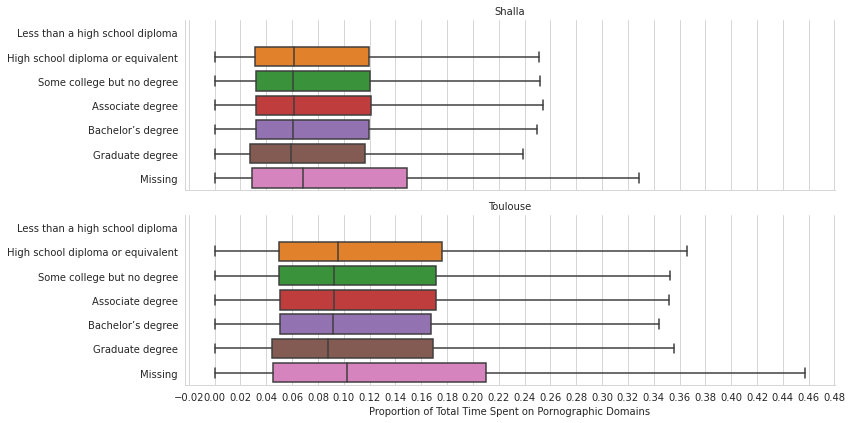

In [35]:
adf = pd.melt(df, id_vars=['hoh_most_education'], value_vars=grp_prop_time, var_name='model', value_name='prop_total_time_porn_prob')
adf['model'] = adf['model'].replace({'prop_total_time_porn_shalla': 'Shalla', 'prop_total_time_porn_toulouse': 'Toulouse'})

g = sns.catplot(x="prop_total_time_porn_prob", y="hoh_most_education",
                col='model', col_wrap=1, height=3, aspect=4,
                kind="box", data=adf, showfliers=False, order=edu.values());
g.set_ylabels('');
g.set_titles(row_template = '{row_name}', col_template = '{col_name}')
g.set_xlabels('Proportion of Total Time Spent on Pornographic Domains')

for ax in g.axes.flatten():
    ax.xaxis.set_major_locator(tkr.MultipleLocator(0.02))
    ax.xaxis.set_minor_locator(tkr.MultipleLocator(0.005))

g.savefig('./prop_total_time_porn_educ_2016.eps', format='eps', dpi=300)    